<a href="https://colab.research.google.com/github/butaud/makemore/blob/main/building_makemore_part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-03-12 17:49:57--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.09s   

2024-03-12 17:49:58 (2.35 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


### Define hyperparameters

In [6]:
BLOCK_SIZE = 3
EMBEDDING_DIMENSIONALITY = 10
INPUT_NEURON_COUNT = BLOCK_SIZE * EMBEDDING_DIMENSIONALITY
HIDDEN_LAYER_SIZE = 200

In [7]:
# build the dataset

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * BLOCK_SIZE
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Initialize the model

In [45]:
# model params
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, EMBEDDING_DIMENSIONALITY), generator=g)
W1 = torch.randn((INPUT_NEURON_COUNT, HIDDEN_LAYER_SIZE), generator=g) * (5/3) / (INPUT_NEURON_COUNT ** 0.5)
#b1 = torch.randn(HIDDEN_LAYER_SIZE, generator=g) * 0.01
W2 = torch.randn((HIDDEN_LAYER_SIZE, vocab_size), generator=g) * .01
b2 = torch.randn(vocab_size, generator=g) * 0

# Batch normalization params
bngain = torch.ones((1, HIDDEN_LAYER_SIZE))
bnbias = torch.zeros((1, HIDDEN_LAYER_SIZE))
bnmean_running = torch.zeros((1, HIDDEN_LAYER_SIZE))
bnstd_running = torch.ones((1, HIDDEN_LAYER_SIZE))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12097


In [26]:
# learning characteristics
BATCH_SIZE = 32
TRAINING_PASSES = 200000
START_STEP_SIZE = 0.1
END_STEP_SIZE = 0.01

def calculate_learning_rate(current_pass, total_passes):
  #lr_decrease = (START_STEP_SIZE - END_STEP_SIZE) / (total_passes)
  #current_lr = START_STEP_SIZE - lr_decrease * current_pass
  current_lr = START_STEP_SIZE if current_pass < TRAINING_PASSES / 2 else END_STEP_SIZE
  return current_lr

In [46]:
lri = []
lossi = []

for i in range(TRAINING_PASSES):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,), generator=g)

  # forward pass
  emb = C[Xtr[ix]] # (BATCH_SIZE, BLOCK_SIZE, EMBEDDING_DIMENSIONALITY)
  embcat = emb.view(-1, INPUT_NEURON_COUNT)
  # Linear layer
  hpreact = embcat @ W1 #+ b1
  # BatchNorm layer
  # ----------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact_norm = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # ---------------------------------

  # Non-linearity
  h = torch.tanh(hpreact_norm) # (BATCH_SIZE, HIDDEN_LAYER_SIZE)
  logits = h @ W2 + b2 # (BATCH_SIZE, DICT_SIZE)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = calculate_learning_rate(i, TRAINING_PASSES)
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lr)
  lossi.append(loss.log10().item())
  if i % 10000 == 0:
    print(f'{i:7d}/{TRAINING_PASSES:7d}: {loss.item():.4f}')

  #break

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


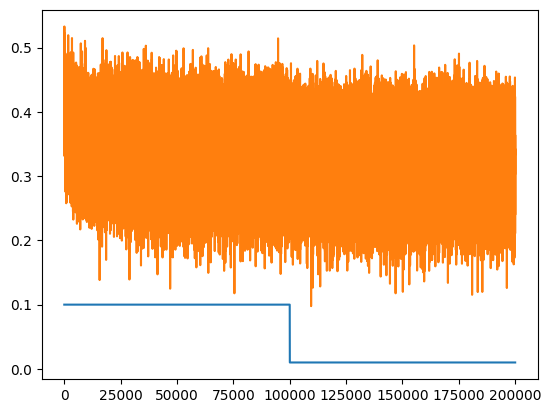

In [47]:
plt.plot(lri)
plt.plot(lossi)

In [48]:
@torch.no_grad()
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte)
  }[split]
  emb = C[x] # (split size, BLOCK_SIZE, EMBEDDING_DIMENSIONALITY)
  embcat = emb.view(-1, INPUT_NEURON_COUNT) # (split size, INPUT_NEURON_COUNT)
  hpreact = embcat @ W1 #+ b1
  hpreact_norm = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact_norm) # (split size, HIDDEN_LAYER_SIZE)
  logits = h @ W2 + b2 # (split size, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.0674147605895996
val 2.1056840419769287


In [49]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * BLOCK_SIZE # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      hpreact = emb.view(1, -1) @ W1 #+ b1
      hpreact_norm = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
      h = torch.tanh(hpreact_norm)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
ndheyah.
reisha.
endraeg.
adelynnelin.
shy.
jen.
eden.
sana.
arleigh.
malaia.
nosadhvighairiel.
kindreelynn.
novana.
uberted.
ryyah.
faeha.
kayshayklynn.


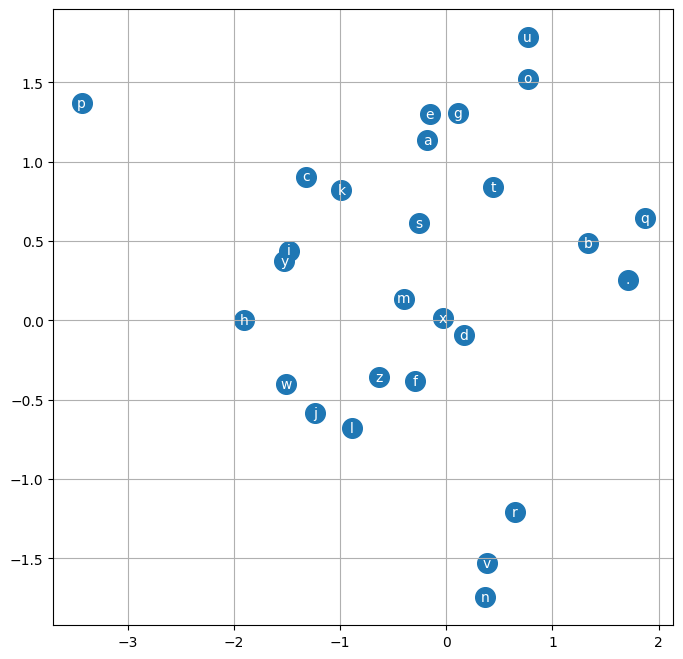

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')